In [56]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import os
import collections
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [72]:
data = pd.read_csv('.\second_cars_info.csv')#

In [73]:
data.head()

,Brand,Name,Boarding_time,Km,Discharge,Sec_price,New_price
0,奥迪,奥迪A6L 2006款 2.4 CVT 舒适型,2006年8月,9.00万公里,国3,6.90,50.89
1,奥迪,奥迪A6L 2007款 2.4 CVT 舒适型,2007年1月,8.00万公里,国4,8.88,50.89
2,奥迪,奥迪A6L 2004款 2.4L 技术领先型,2005年5月,15.00万公里,国2,3.82,54.24
3,奥迪,奥迪A8L 2013款 45 TFSI quattro舒适型,2013年10月,4.80万公里,欧4,44.80,101.06
4,奥迪,奥迪A6L 2014款 30 FSI 豪华型,2014年9月,0.81万公里,"国4,国5",33.19,54.99


In [74]:
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

### 数据清洗

In [75]:
data = data.loc[data.Boarding_time != '未上牌',:]#吧boarding_time是未上牌的删除掉
data.index = range(0,data.shape[0])#重新设置索引
data['year'] = data.Boarding_time.str[:4].astype('int')#再取出上牌时间的年月
month = data.Boarding_time.str.findall('年(.*?)月')
print(month.head(10))
month = pd.Series([i[0] for i in month]).astype('int')
data['month'] = month

0     [8]
1     [1]
2     [5]
3    [10]
4     [9]
5     [8]
6     [9]
7     [7]
8     [5]
9     [8]
Name: Boarding_time, dtype: object


In [76]:
data['diff_months'] = (2022-data.year)*12 + (2-data.month) + 1#计算上牌时间到现在2022年2月份的月数
data.head()

,Brand,Name,Boarding_time,Km,Discharge,Sec_price,New_price,year,month,diff_months
0,奥迪,奥迪A6L 2006款 2.4 CVT 舒适型,2006年8月,9.00万公里,国3,6.90,50.89,2006,8,187
1,奥迪,奥迪A6L 2007款 2.4 CVT 舒适型,2007年1月,8.00万公里,国4,8.88,50.89,2007,1,182
2,奥迪,奥迪A6L 2004款 2.4L 技术领先型,2005年5月,15.00万公里,国2,3.82,54.24,2005,5,202
3,奥迪,奥迪A8L 2013款 45 TFSI quattro舒适型,2013年10月,4.80万公里,欧4,44.80,101.06,2013,10,101
4,奥迪,奥迪A6L 2014款 30 FSI 豪华型,2014年9月,0.81万公里,"国4,国5",33.19,54.99,2014,9,90


In [ ]:
data['Km_new']=data['Km'].str[:-3]#处理掉KM字段中的万公里字符串
data['Km_new']=data.Km_new.astype('float')


### 会报错，因为还有百公里内这种值，先计算其占比，再决定是否删除或填充

In [81]:
N = np.sum(data.Km == '百公里内')
Ratio = N/data.shape[0]
Ratio
#百公里内占比，数值很小，将百公里内替换成0.005万公里
data.Km_new.replace('百','0.005',inplace=True)

In [82]:
data.Km_new=data.Km_new.astype('float')
data.head()

,Brand,Name,Boarding_time,Km,Discharge,Sec_price,New_price,year,month,diff_months,Km_new
0,奥迪,奥迪A6L 2006款 2.4 CVT 舒适型,2006年8月,9.00万公里,国3,6.90,50.89,2006,8,187,9.00
1,奥迪,奥迪A6L 2007款 2.4 CVT 舒适型,2007年1月,8.00万公里,国4,8.88,50.89,2007,1,182,8.00
2,奥迪,奥迪A6L 2004款 2.4L 技术领先型,2005年5月,15.00万公里,国2,3.82,54.24,2005,5,202,15.00
3,奥迪,奥迪A8L 2013款 45 TFSI quattro舒适型,2013年10月,4.80万公里,欧4,44.80,101.06,2013,10,101,4.80
4,奥迪,奥迪A6L 2014款 30 FSI 豪华型,2014年9月,0.81万公里,"国4,国5",33.19,54.99,2014,9,90,0.81


In [85]:
data=data.loc[data.New_price!='暂无']#类型转换会报错，因为有’暂无‘字段
data.New_price=data.New_price.astype('float')

D:\anaconda\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [86]:
data.describe()

,Sec_price,New_price,year,month,diff_months,Km_new
count,11047.000000,11047.000000,11047.000000,11047.000000,11047.000000,11047.000000
mean,26.081886,51.725339,2011.669141,6.653571,120.316738,6.230649
std,53.401052,80.081184,3.003765,3.346884,35.880047,3.502620
min,0.650000,2.910000,1997.000000,1.000000,53.000000,0.005000
25%,5.200000,16.160000,2010.000000,4.000000,92.000000,3.990000
50%,10.350000,26.790000,2012.000000,7.000000,121.000000,6.000000
75%,23.980000,52.730000,2014.000000,9.000000,144.000000,8.200000
max,808.000000,976.920000,2017.000000,12.000000,291.000000,34.600000


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11047 entries, 0 to 11187
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11047 non-null  object 
 1   Name           11047 non-null  object 
 2   Boarding_time  11047 non-null  object 
 3   Km             11047 non-null  object 
 4   Discharge      11047 non-null  object 
 5   Sec_price      11047 non-null  float64
 6   New_price      11047 non-null  float64
 7   year           11047 non-null  int32  
 8   month          11047 non-null  int32  
 9   diff_months    11047 non-null  int32  
 10  Km_new         11047 non-null  float64
dtypes: float64(3), int32(3), object(5)
memory usage: 906.2+ KB


## 经过数据清洗，一部分值被删除，一部分被替换，共减少234条样本，接下来可视化进行数据探索

### 1、先看销量分布，由于二手车市场品牌众多，可能会有垄断，先看销量前十

In [89]:
word_counts = collections.Counter(data['Brand']) # 对分词做词频统计
word_counts_top10 = word_counts.most_common(10) # 获取前10最高频的词

In [90]:
plt.rcParams['figure.figsize'] = (10, 7)

In [92]:
brand=[]
brand_num=[]
for i in range(0,10):
    brand.append(word_counts_top10[i][0])
    brand_num.append(word_counts_top10[i][1])
brand.append('其他')
brand_num.append(data.shape[0] - sum(brand_num))

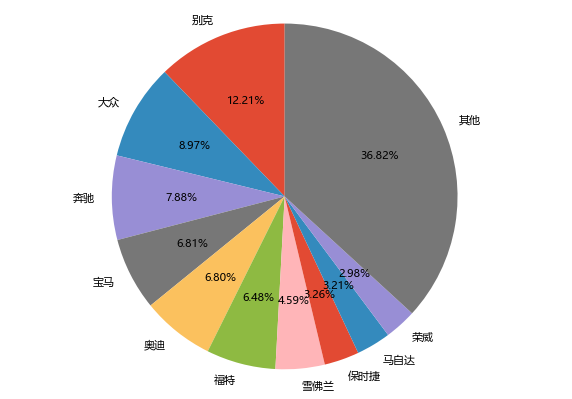

In [93]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.pie(brand_num, labels=brand,autopct='%1.2f%%',startangle=90,radius = 1.5,textprops={'fontsize':11,'color':'black'})
plt.axis('equal')
plt.show()

#### 销量前十占了总体的63.18%，除了品牌，不同款式不同年份销量也不同，下面按照款式年份统计分析

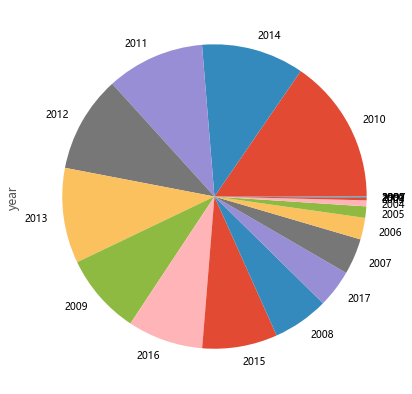

In [104]:
type_year = data['year'].value_counts()
type_year.plot(kind = 'pie')

#### 二手车交易主要年份是在2009-2016之间

### 2、销售额分析。销量高不一定销售额高

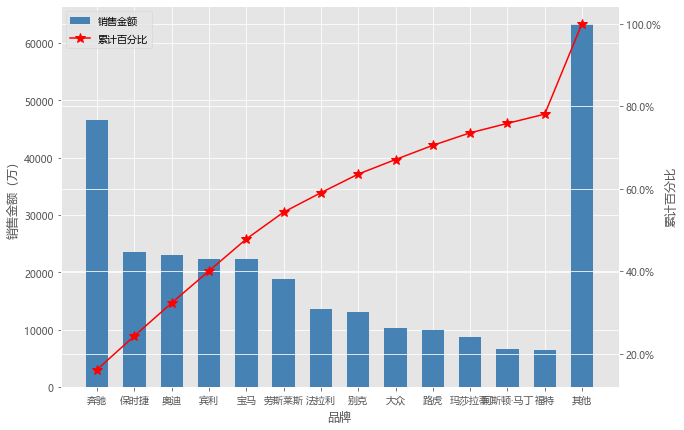

In [115]:
weight_sum = pd.DataFrame(data.groupby('Brand',as_index=False)['Sec_price'].sum())
weight_sum = weight_sum.sort_values('Sec_price',ascending=False)

brand = weight_sum['Brand'].tolist()
secprice = weight_sum['Sec_price'].tolist()

brand = brand[:13]
brand.append('其他')
secprice1 = []
for i in range(0,13):
    secprice1.append(sum(secprice[:i+1]))
secprice1.append(sum(secprice))
secprice = secprice[:13]
secprice.append(secprice1[-1] - secprice1[-2])

pricepc = []
for i in range(0,14):
    pricepc.append(secprice1[i] / secprice1[-1] * 100)
    
plt.bar(brand,secprice, width=0.6, align='center', label=u"销售金额",color='steelblue')
plt.xlabel(u"品牌")
plt.ylabel(u"销售金额（万）")
handles1, labels1 = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(brand, pricepc ,"r", marker='*', ms=10, label=u"累计百分比")
fmt = '%.1f%%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)
plt.ylabel(u"累计百分比")
handles2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc='upper left')

#### 可以看出，奔驰的销售额是所有二手车最高的，其次是保时捷，宾利等。并且销售额前13位的总金额占了总销售额的接近80%

### 3、排放标准分析

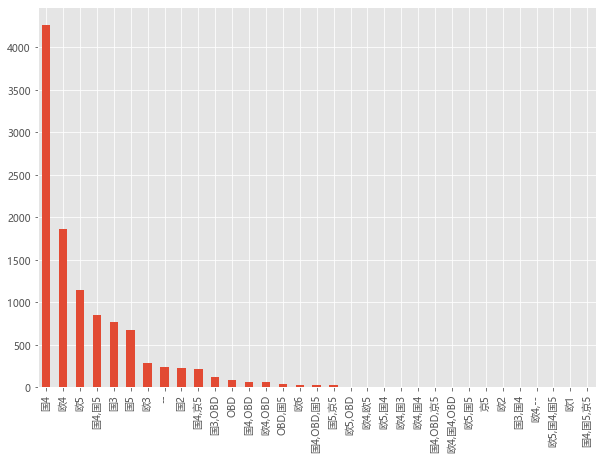

In [109]:
discharge = data['Discharge'].value_counts()
discharge.plot(kind = 'bar')

### 4、折损率分析

In [110]:
data['折损'] = data.apply(lambda x: x['Sec_price'] / x['New_price'], axis=1)

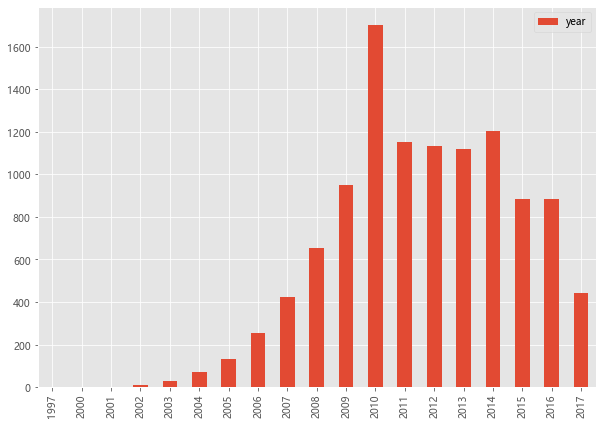

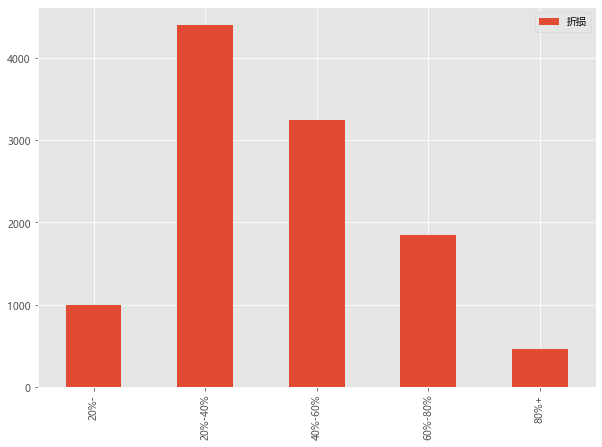

In [122]:
car_year = data['year'].value_counts()
car_year.to_frame().sort_index().plot(kind = 'bar')
zhesunBins = [0,0.2,0.4,0.6,0.8,1]
zhesunlabels = ['20%-','20%-40%','40%-60%','60%-80%','80%+']
zs = pd.cut(data['折损'], bins=zhesunBins, labels=zhesunlabels, include_lowest=True)
zs.value_counts().to_frame().sort_index().plot(kind = 'bar')


#### 其中成交量最多的是2010年上牌的车


### 5、公里处数分析

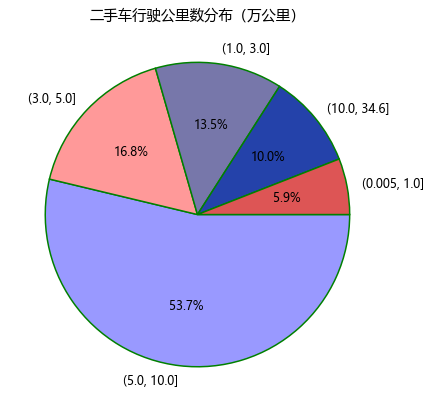

In [116]:
km_min = data.Km_new.min()
km_max = data.Km_new.max()
# 指定任意的切割点，将数据分段
km_cuts = pd.cut(data.Km_new, bins = [km_min, 1,3,5,10,km_max])
km_stats = km_cuts.value_counts()
km_stats

# 绘制饼图
# 将横、纵坐标轴标准化处理，保证饼图是一个正圆，否则为椭圆
plt.axes(aspect='equal')
# 提取出索引作为标签
labels = km_stats.index
# 自定义颜色
colors=['#9999ff','#ff9999','#7777aa','#2442aa','#dd5555'] 

# 绘制饼图
plt.pie(km_stats.values,
        labels=labels, 
        colors = colors, # 设置颜色
        autopct='%.1f%%', # 设置百分比的格式，这里保留一位小数
        counterclock = False, # 设置为顺时针方向
        wedgeprops = {'linewidth': 1.5, 'edgecolor':'green'},# 设置饼图内外边界的属性值
        textprops = {'fontsize':12, 'color':'k'} # 设置文本标签的属性值
       )

# 添加图标题
plt.title('二手车行驶公里数分布（万公里）')
# 显示图形   
plt.show()

### 6、二手车价格区间统计

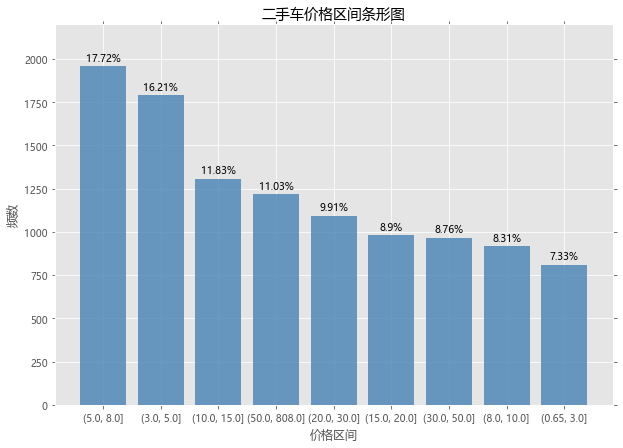

In [118]:
# 指定任意的切割点，将数据分段
price_cuts = pd.cut(data.Sec_price, bins = [min_price,3,5,8,10,15,20,30,50,max_price])

# 按照数据段，进行数据的统计，即频数统计
price_stats = price_cuts.value_counts()

x = range(len(price_stats))
# 将索引用作绘图的刻度标签
label = price_stats.index
# 占比用于绘图的数值标签
percent = [str(round(i*100,2))+'%' for i in price_stats/price_stats.sum()]
# 绘图
plt.bar(x, # x轴数据
        price_stats, # y轴数据
        align = 'center', # 刻度居中对齐
        color='steelblue', # 填充色
        alpha = 0.8 # 透明度
       )

# 设置y轴的刻度范围
plt.ylim(0,2200)
# x轴刻度标签
plt.xticks(x,label)

# 设置坐标轴标签和标题
plt.title('二手车价格区间条形图')
plt.xlabel('价格区间')
plt.ylabel('频数')

# 去除图形顶部边界和右边界的刻度
plt.tick_params(top='off', right='off')

# 为每个条形图添加数值标签
for x,y,z in zip(x,price_stats,percent):
    plt.text(x, y+30,'%s' %z,ha='center')

# 显示图形
plt.show()


#### 10万以内的二手车占比达到了40%以上

### 7、相关性热图分析

D:\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


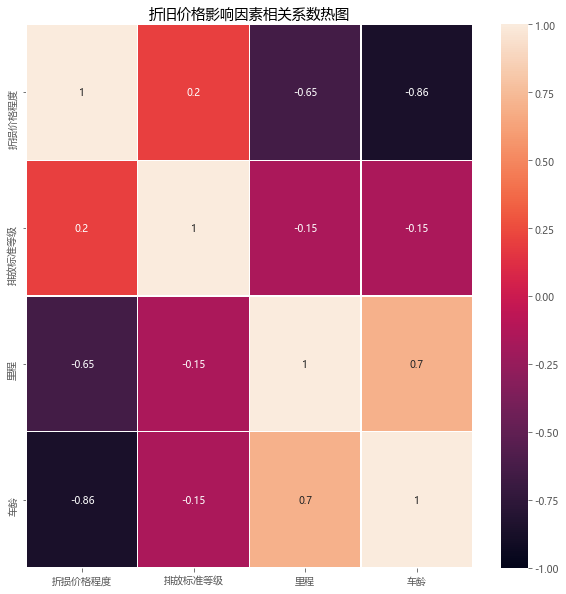

In [151]:
data['Discharge_level'] = 1
discharge_list = ['欧1','国2','欧2','国3','欧3','国4','欧4','国5','欧5','京5','欧6']
for i in discharge_list:
    data['Discharge_level'].loc[data['Discharge'] == i] = discharge_list.index(i) + 1
data['Discharge_level'].loc[data['Discharge'] == '--'] = None

names = ['折损价格程度','排放标准等级','里程','车龄']
zhejiu = data[['折损','Discharge_level','Km_new','diff_months']]
correction = zhejiu.corr() 
plt.figure(figsize=(10,10))
sns.heatmap(correction,cmap=None, linewidths=0.05,vmax=1, vmin=-1 ,annot=True,annot_kws={'size':10,'weight':'normal'})
plt.xticks(np.arange(4)+0.5,names)
plt.yticks(np.arange(4)+0.5,names)
plt.title('折旧价格影响因素相关系数热图')
plt.show()


### 可以看出，车龄与折损价格程度=secprice/newprice呈负相关，车龄越高，程度越低，二手价格越低